In [9]:
import synthpop 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

In [18]:
%load_ext autoreload
%autoreload 2

In [10]:
ccyc = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

In [11]:
# Imports
import pysiaf
from pysiaf.utils.rotations import attitude
# Read in the Roman SIAF
rsiaf = pysiaf.Siaf('Roman')
wfi_cen=rsiaf['WFI_CEN']
roman_apertures = [f'WFI{i + 1:02}_FULL' for i in range(18)]

In [12]:
def compile_edges(l,b, pa_v3):
    edge_corners = [[7, 2], [9,1], [9,0], [6,1], [6,0], [3,1], [12,0], [15,1], [15,0],
                    [18,1], [18,0], [16,3], [16,2], [13,3], [13,2], [10,3], [1,2],
                    [4,3], [4,2], [7,3], [7,2]]
    all_corners = []
    #l_out, b_out = [], []
    coord = SkyCoord(l=l, b=b, unit=u.deg, frame='galactic').transform_to('icrs')
    boresight_ra = coord.ra.degree
    boresight_dec = coord.dec.degree
    att = attitude(wfi_cen.V2Ref, wfi_cen.V3Ref, boresight_ra, boresight_dec, pa_v3)

    for j,rap in enumerate(roman_apertures):
        wfi_ap = rsiaf[rap]
        wfi_ap.set_attitude_matrix(att)
        ra,dec = wfi_ap.closed_polygon_points('sky')
        lb = SkyCoord(ra=ra, dec=dec, unit=u.deg, frame='icrs').transform_to('galactic')
        mid_l = np.mean((lb.l.degree-360*(lb.l.degree>180))[:-1])
        mid_b = np.mean(lb.b.degree[:-1])
        #plt.text(mid_l,mid_b, rap, va='center', ha='center')
        #plt.plot((lb.l.degree-360*(lb.l.degree>180)),lb.b.degree)
        all_corners.append(np.transpose([lb.l.degree-360*(lb.l.degree>180),lb.b.degree]))
        #plt.plot(mid_l,mid_b, '.')
    pt_corners = [all_corners[edge_corners[i][0]-1][edge_corners[i][1]] for i in range(len(edge_corners))]
    #plt.plot(*np.transpose(pt_corners), 'k')
    wfi_cen.set_attitude_matrix(att)
    radec = wfi_cen.idl_to_sky(0, 0)
    lb = SkyCoord(ra=radec[0],dec=radec[1], unit=u.deg, frame='icrs').transform_to('galactic')
    #plt.plot(lb.l.degree-360*(lb.l.degree>180), lb.b.degree, 'k.', markersize=10)
    #plt.gca().invert_xaxis()
    return np.transpose(pt_corners)

0.015717095275689343


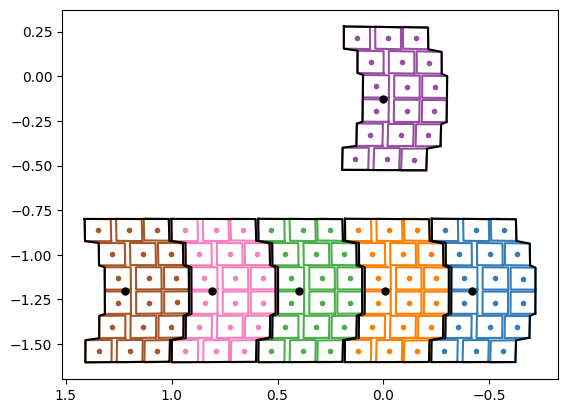

In [13]:
def plot_fields(flds):
    frds = SkyCoord(l=flds[:,0], b=flds[:,1], unit=u.deg, frame='galactic').transform_to('icrs')
    # Set the boresight position and roll angle
    cent_list = np.zeros((len(frds)*len(roman_apertures),2))
    field_list = []; chip_list = []
    k=0
    for i,frd in enumerate(frds):
        boresight_ra = frd.ra.degree
        boresight_dec = frd.dec.degree
        pa_v3 = 90.75
        att = attitude(wfi_cen.V2Ref, wfi_cen.V3Ref, boresight_ra, boresight_dec, pa_v3)

        for j,rap in enumerate(roman_apertures):
            wfi_ap = rsiaf[rap]
            wfi_ap.set_attitude_matrix(att)
            ra,dec = wfi_ap.closed_polygon_points('sky')
            lb = SkyCoord(ra=ra, dec=dec, unit=u.deg, frame='icrs').transform_to('galactic')
            mid_l = np.mean((lb.l.degree-360*(lb.l.degree>180))[:-1])
            mid_b = np.mean(lb.b.degree[:-1])
            cent_list[k]=[np.round(mid_l,3), np.round(mid_b,3)]
            field_list.append(i+1), chip_list.append(j+1)
            plt.plot(lb.l.degree-360*(lb.l.degree>180),lb.b.degree,c=ccyc[i])
            plt.plot(mid_l,mid_b, '.', c=ccyc[i])
            if i==5 and j==0:
                print((max(lb.l.degree-360*(lb.l.degree>180))-min(lb.l.degree-360*(lb.l.degree>180)))*(max(lb.b.degree)-min(lb.b.degree)))
            k+=1
        wfi_cen.set_attitude_matrix(att)
        radec = wfi_cen.idl_to_sky(0, 0)
        lb = SkyCoord(ra=radec[0],dec=radec[1], unit=u.deg, frame='icrs').transform_to('galactic')
        plt.plot(*compile_edges(lb.l.degree, lb.b.degree, pa_v3), c='k')
        plt.plot(lb.l.degree-360*(lb.l.degree>180), lb.b.degree, 'k.', markersize=10)
    plt.gca().invert_xaxis()
    
    df = pd.DataFrame({'Nfield': field_list,
                   'Nchip': chip_list,
                   'l': cent_list[:,0],
                   'b': cent_list[:,1]})
    return df
df = plot_fields(np.loadtxt('field_centers_overguide.txt', skiprows=1))

In [14]:
df.to_csv('overguide_chip_centers.dat', index=False, sep=' ')

In [111]:
# Chip size from pixel count and plate scale
(4096*0.11 / (60*60))

0.12515555555555555